In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Enable multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
#%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import pandas as pd
import numpy as np
from Color import *
from operator import truediv

# Matplotlib font configuration
from MatplotlibFonts import *

# Change the font size
rcParams.update({"font.size": 15})

In [3]:
RESULT_DIR='../icemu/log/'

In [22]:
# Benchmarks in order
Benchmarks = [
    'coremark',
    'sha',
    'crc',
    'aes',
    'dijkstra',
    'picojpeg'
]

# Configurations in order
Configurations = [
    'nacho-naive',
    'nacho-pw',
    'nacho-clank'
    # 'prowl'
]

Stats = [
    'checkpoints','cycle count','last checkpoint','dirty ratio','cause'
]

CacheConfig = [ "-512-2-", "-256-2-", "-1024-2-"]

FinalStats = [
    'cache_miss', 
    'cache_hit', 
    'cache_read', 
    'cache_write', 
    'cache_cuckoo', 
    'cache_checkpoint', 
    'nvm_reads_no_cache', 
    'nvm_writes_no_cache', 
    'nvm_reads', 
    'nvm_writes', 
    'checkpoint', 
    'checkpoint_war', 
    'checkpoint_dirty', 
    'checkpoint_period', 
    'checkpoint_max_cycles', 
    'hints_given', 
    'max_dirty_ratio', 
    'cuckoo_iter'
]

from BenchmarkConfiguration import *

In [5]:
df = {}
df['nacho-naive'] = {}
df['nacho-naive']['aes'] = pd.read_csv(RESULT_DIR + "aes" + "-nacho-clank" + CacheConfig[0] + "cont").set_index("checkpoints")
df['nacho-naive']['aes']

,cycle count,last checkpoint,dirty ratio,cause
checkpoints,,,,
1,2909,2909,0.359375,0
2,6970,4061,0.117188,0
3,7086,116,0.031250,0
4,7125,39,0.031250,0
5,7164,39,0.031250,0
...,...,...,...,...
146,199740,133,0.031250,0
147,199778,38,0.031250,0
148,199816,38,0.031250,0


In [6]:
# Load the benchmarks
def load_cont_stats(bench, config, cache):
    file = RESULT_DIR + bench + "-" + config + cache
    return pd.read_csv(file + "cont").set_index("checkpoints")

def load_final_stats(bench, config, cache):
    file = RESULT_DIR + bench + "-" + config + cache
    return dict(pd.read_csv(file + "final", delimiter=":", header = None).values)

cont_stats = {}
final_stats = {}
for cache in CacheConfig:
    cont_stats[cache] = {}
    final_stats[cache] = {}
    for config in Configurations:
        cont_stats[cache][config] = {}
        final_stats[cache][config] = {}
        for bench in Benchmarks:
            cont_stats[cache][config][bench] = load_cont_stats(bench, config, cache)
            final_stats[cache][config][bench] = load_final_stats(bench, config, cache)

In [34]:
cont_stats['-512-2-']['prowl']['sha']['cycle count'][:1]


checkpoints
380    1000005
Name: cycle count, dtype: int64

In [23]:
from Color import *

X = np.arange(len(Benchmarks))
step_size = 1 / (len(Configurations) + 1) 

cache_config_used = None

def fetchNormalizingFactor(bmark, requested_stats):
    normalizing_factor = []
    for b in final_stats[cache_config_used][bmark]:
        val = 0
        for e in requested_stats:
            val = val + final_stats[cache_config_used][bmark][b][e]
        
        normalizing_factor.append(val)

    return normalizing_factor


def plotStatPerBenchmark(ax, requested_stats, normalizing_bmark, title, mean_stat = "dirty_ratio"):
    step = 0.00
    idx_work = 0
    put_a_x = 0
    
    ax.set_ylabel('Normalized ratio')
    ax.set_title(title + ' normalized to ' + normalizing_bmark)
    if title == "":
        ax.set_title("")

    normalize = fetchNormalizingFactor(normalizing_bmark, requested_stats)
    
    # For each work
    for works in final_stats[cache_config_used]:        
        to_plot = np.zeros(len(Benchmarks))
        idx_stat = 0
        
        # For each stack in the bar plot - stats
        for stats in requested_stats:
#             print("For " + str(stats))
            curr_stats = []
            
            # For each bmark
            for bmarks in final_stats[cache_config_used][works]:
                curr_stats.append(final_stats[cache_config_used][works][bmarks][stats])
                
            # Normalize the stats
            curr_stats = list(map(truediv, curr_stats, normalize))
            
            # plot the stacked bar
            line = ax.bar(X + step,
                           curr_stats,
                           bottom = to_plot,
                           linewidth = 1,
                           joinstyle = 'miter',
                        #    hatch = patterns[idx_stat],
                           color = StackedBarColors[idx_work][3 - idx_stat],
                           alpha = 1 - 0.15 * idx_stat,
                           edgecolor = 'white',
                           width = 4.5 * step_size / 5)

            # increment the stack
            to_plot = to_plot + curr_stats

            # N colors for N stats
            idx_stat = idx_stat + 1
            # print(idx_stat)
        
        s = 0
        for i in to_plot:
            if (i == 0):
                ax.text(s, 0, "x",
                        color = Color['red'],
                        fontsize = 'x-large')
            s = s + 1
        
        # Three colors for 3 works
        idx_work = idx_work + 1
        # print(idx_work)

        # Separating each bmark
        step = step + step_size

In [24]:
def plotAvgLineAndLegend(ax, line_data=None):
    if (line_data is not None):
        for work in final_stats[cache_config_used]:
            points = []
            points_max = []
            for bmark in cont_stats[cache_config_used][work]:
                sum_val = np.asarray(cont_stats[cache_config_used][work][bmark][line_data].values).sum()
                if sum_val == 0:
                    points.append(0)
                    points_max.append(1)
                    continue
                avg_val = np.asarray(cont_stats[cache_config_used][work][bmark][line_data].values).mean()
                max_val = np.asarray(cont_stats[cache_config_used][work][bmark][line_data].values).max()
                points.append(avg_val)
                points_max.append(max_val)
                
            points = list(map(truediv, points, points_max))

            ax.plot(X + step_size, points, '-o', label=work + '\navg ' + line_data)

# 512Kb cache for different stats

(-0.25, 5.85)

(-0.25, 5.85)

(-0.25, 5.85)

Text(60.3029478080246, 0.5, 'Normalized ')

Text(0.5, 1.0, 'test')

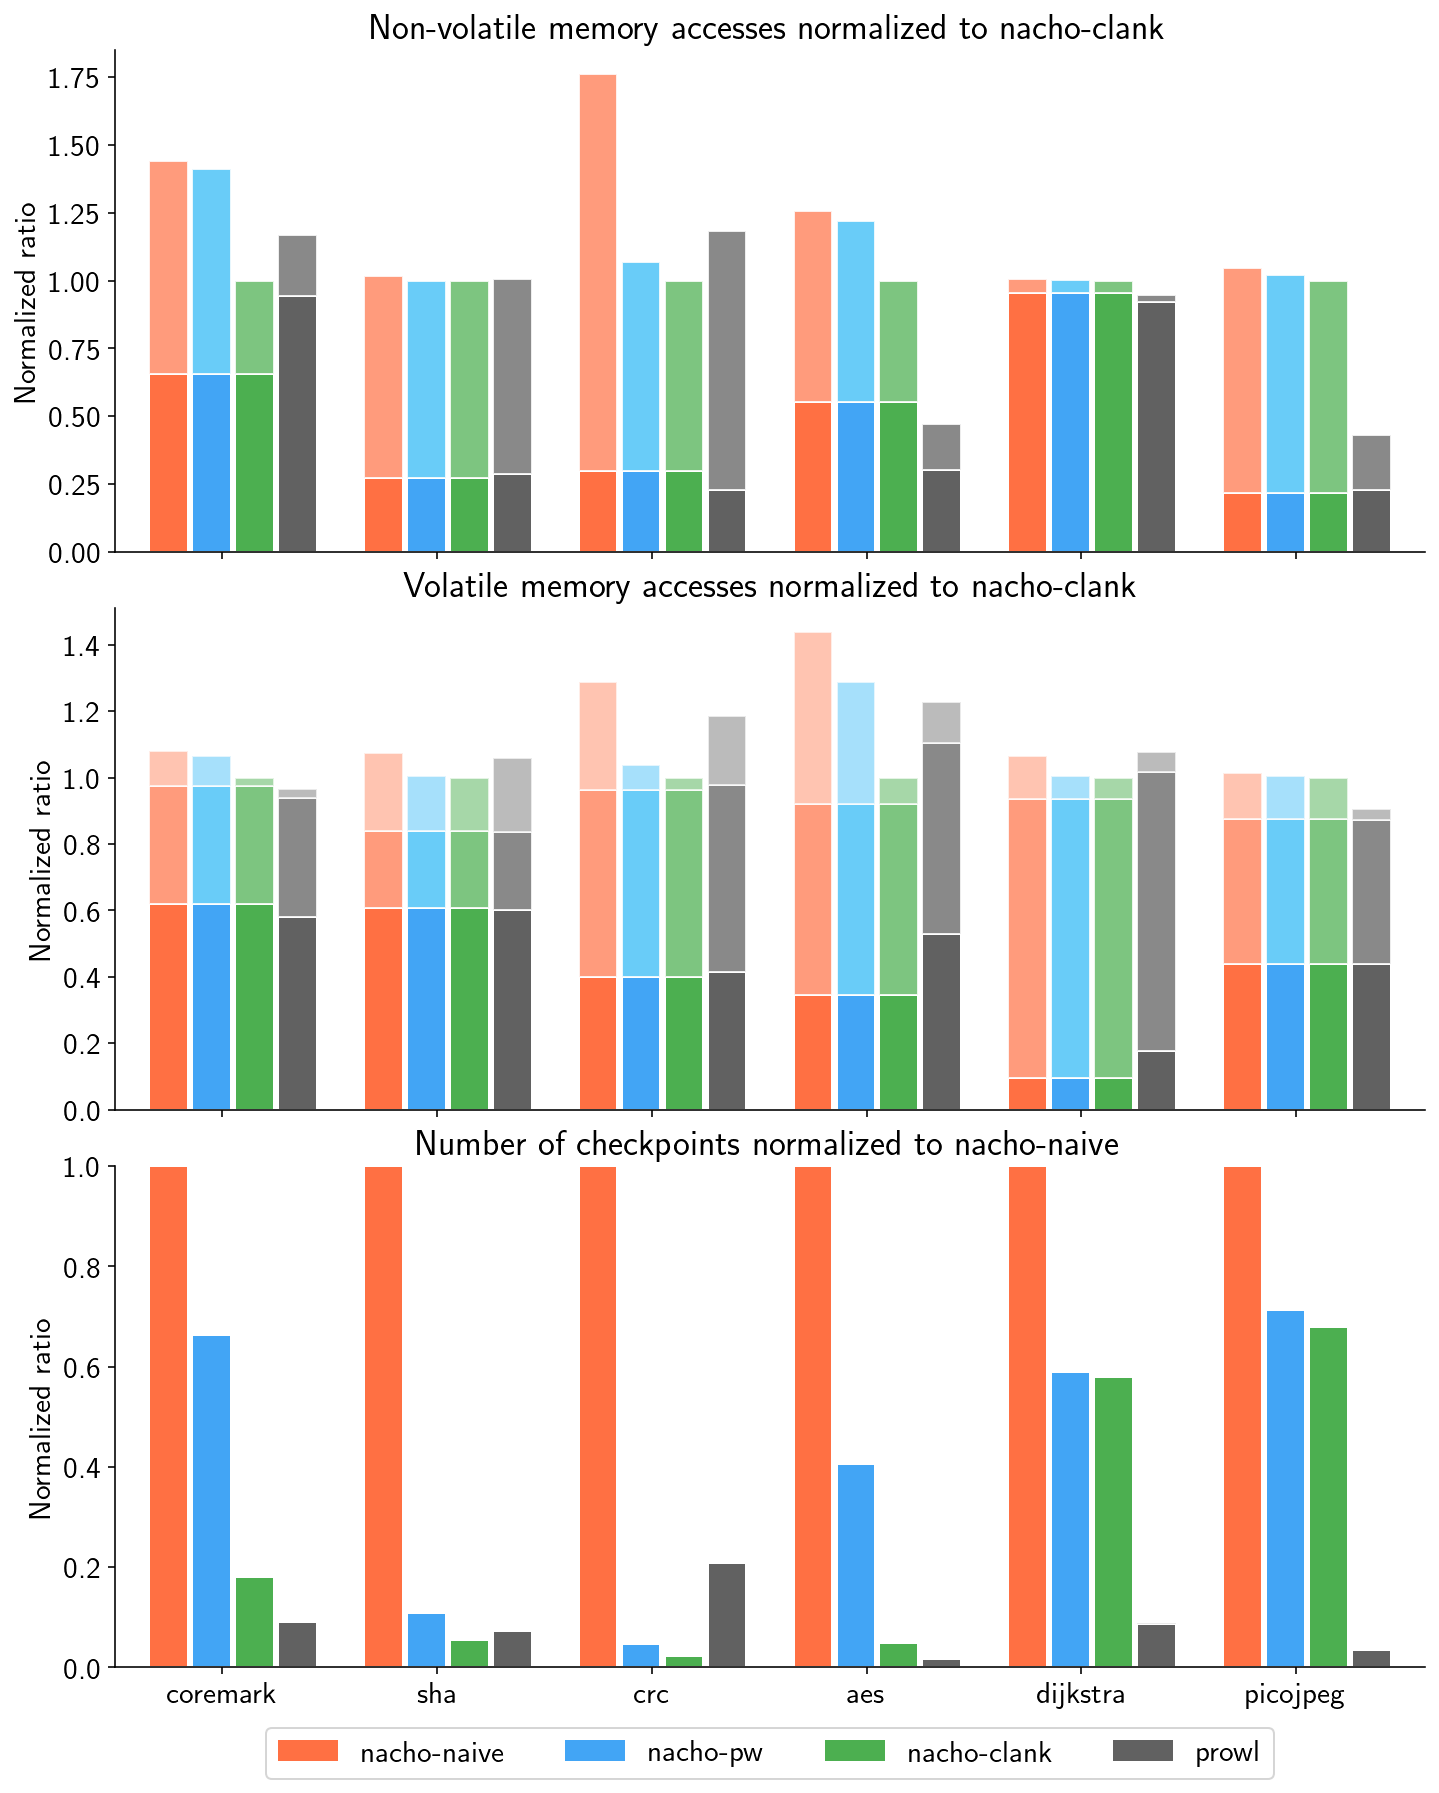

In [10]:
cache_config_used = "-512-2-"
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,12));
fig.tight_layout(pad=1);

for a in ax:
    # a.set_ylim(bottom=0, top=1.8)
    a.set_xlim(-0.25,5.85)
    a.margins(x=0)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

ax[0].set_xticks(X + 0.25, Benchmarks);

ax[0].set_ylabel('Normalized ');
ax[0].set_title('test');


plotStatPerBenchmark(ax[0], ['nvm_reads', 'nvm_writes'],
                     'nacho-clank',
                     "Non-volatile memory accesses");

plotStatPerBenchmark(ax[1], ['cache_read', 
                      'cache_write',
                      'cache_checkpoint'], 'nacho-clank',
                      'Volatile memory accesses');

plotStatPerBenchmark(ax[2], ['checkpoint_war', 
                      'checkpoint_dirty', 
                      'checkpoint_period',], 'nacho-naive',
                      'Number of checkpoints')

# Add invisible data to add another legend
n=[]
h,l = ax[1].get_legend_handles_labels()
labels = Configurations

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]))

# l1 = axTop.legend(h[:len(Benchmarks)], l[:len(Benchmarks)],
#             bbox_to_anchor=(0., -0.222, 1., .102), 
#             loc='center right',
#             ncol=3,
#             borderaxespad=0., mode="expand")

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(0., -0.222, 1., .102), 
            loc='center',
            ncol=4) 
# axTop.add_artist(l2)

# Stats for different caches

(0.0, 1.1)

(-0.25, 5.85)

(0.0, 1.1)

(-0.25, 5.85)

(0.0, 1.1)

(-0.25, 5.85)

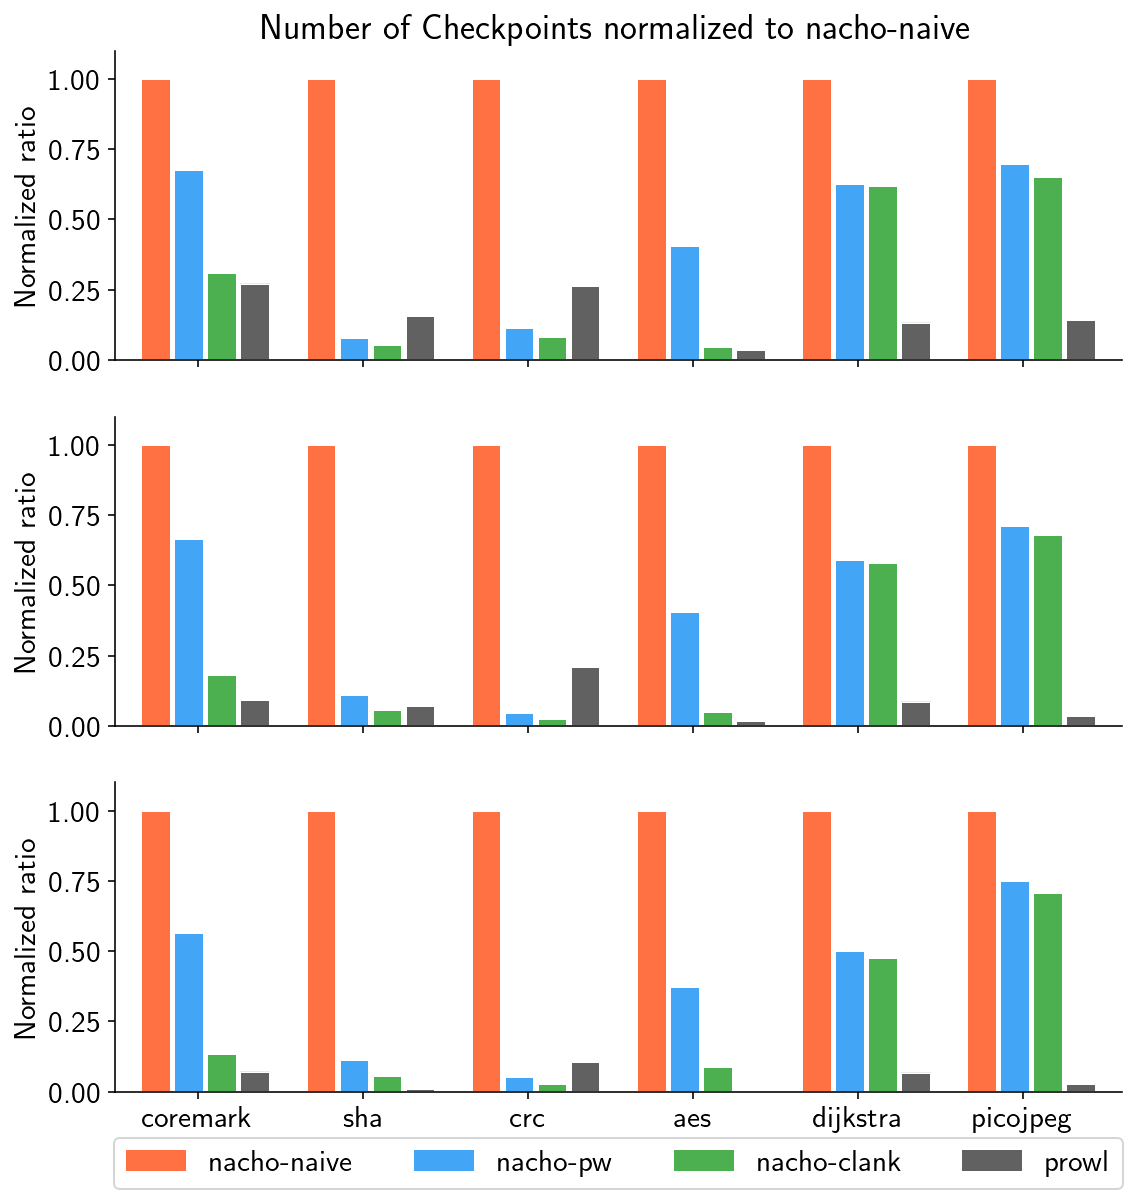

In [11]:

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8,8));
fig.tight_layout(pad=1);
ylegend = 1.0
for a in ax:
    a.set_ylim(0, 1.1)
    a.set_xlim(-0.25,5.85);
    a.margins(x=0);
    a.spines['right'].set_visible(False);
    a.spines['top'].set_visible(False);

ax[0].set_xticks(X + 0.25, Benchmarks);
isCheckpoints = False

# Uncomment/change what stats which are needed to be plotted
# stats_plotted = ['cache_read', 'cache_write', 'cache_checkpoint']
# stats_desc = ['read', 'write', 'checkpoint']
# title = 'Volatile memory accesses'
# normalizationBmark = "nacho-naive"

# stats_plotted = ['nvm_reads', 'nvm_writes']
# stats_desc = ['reads', 'writes']
# title = 'Non volatile memory access'
# normalizationBmark = "nacho-naive"

stats_plotted = ['checkpoint_war', 'checkpoint_dirty', 'checkpoint_period']
stats_desc = ['WAR', 'ditry ratio', 'period']
title = 'Number of Checkpoints'
normalizationBmark = "nacho-naive"
isCheckpoints = True

# Do the actual plotting
cache_config_used = "-256-2-"
plotStatPerBenchmark(ax[0], stats_plotted, normalizationBmark, title);

cache_config_used = "-512-2-"
plotStatPerBenchmark(ax[1], stats_plotted, normalizationBmark, "");

cache_config_used = "-1024-2-"
plotStatPerBenchmark(ax[2], stats_plotted, normalizationBmark, "");

# For the legend
n=[];
h,l = ax[1].get_legend_handles_labels();
labels = Configurations;

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(0., -0.282, 1., .102), 
            loc='center',
            ncol=4);
# axTop.add_artist(l2)

if isCheckpoints is not True:
    # Add a manual legend for the stats
    for a in ax:
        ybase = ylegend
        idx = 0
        xbase = 4.75
        a.add_patch(Rectangle((xbase-0.08, ybase-0.08), 1, 0.1 * len(stats_desc) + 0.2, fill=False));
        for e in stats_plotted:
            statsLegend = a.add_patch(Rectangle((xbase, ybase), 0.2, 0.05));
            statsLegend.set(color=StackedBarColors[3][3 - idx], alpha=1 - 0.15 * idx);
            a.text(xbase + 0.25, ybase, stats_desc[idx], fontsize='small');
            ybase = ybase + 0.1;
            idx = idx + 1;
        a.text(xbase, ybase+0.02, "Accesses during a", fontsize='small');

(0.0, 1.0)

(-0.25, 5.85)

(0.0, 1.0)

(-0.25, 5.85)

(0.0, 1.0)

(-0.25, 5.85)

Text(34.986709993773346, 0.5, '')

Text(34.986709993773346, 0.5, '')

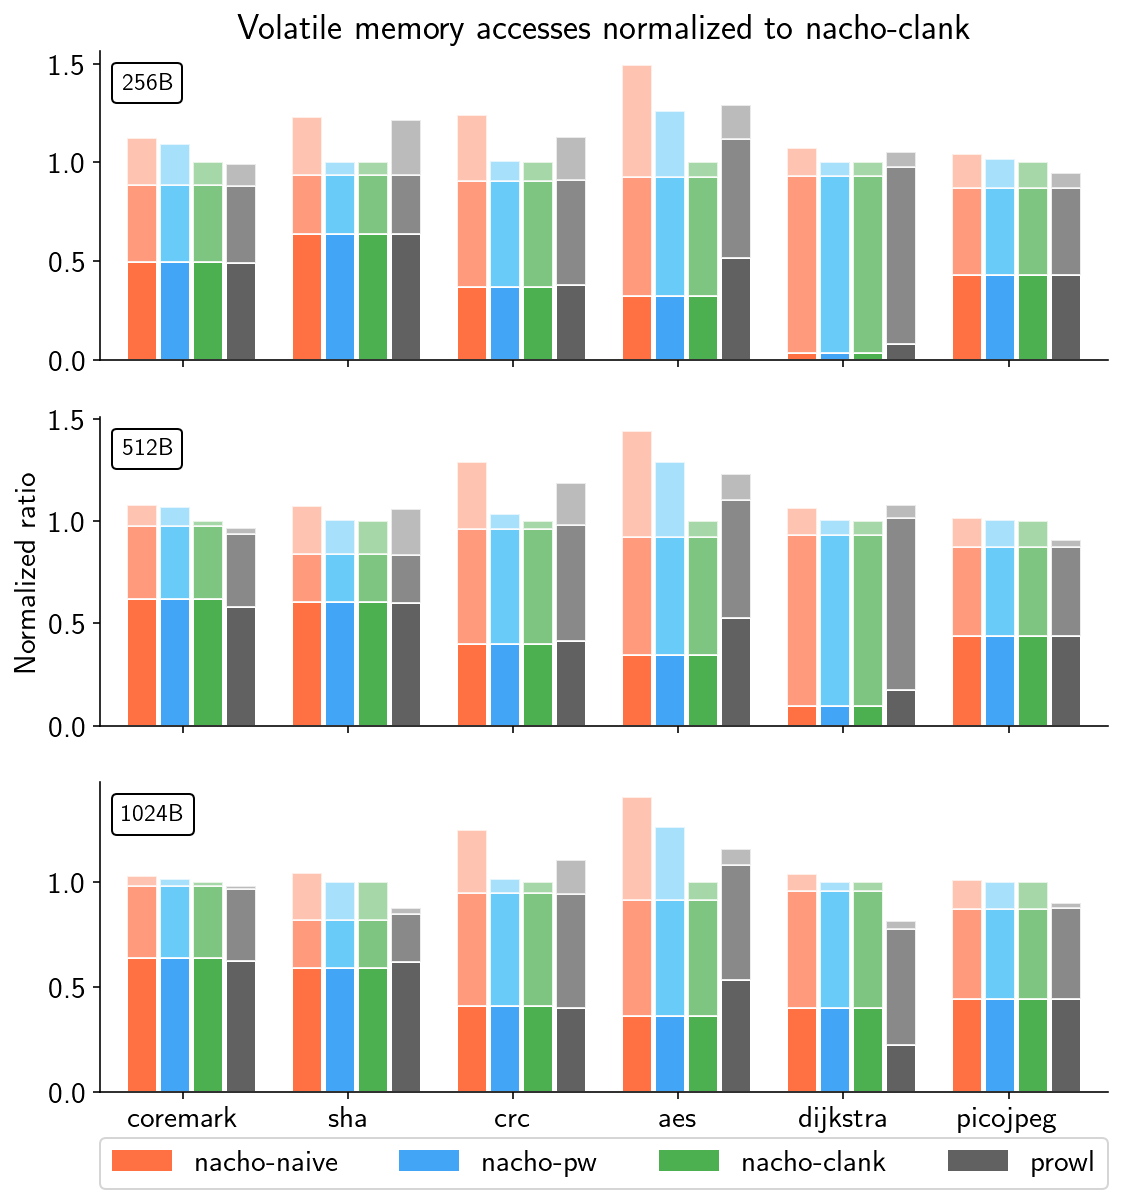

In [20]:

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8,8));
fig.tight_layout(pad=1);
ylegend = 1.2
for a in ax:
    a.set_ylim(auto=True)
    a.set_xlim(-0.25,5.85);
    a.margins(x=0);
    a.spines['right'].set_visible(False);
    a.spines['top'].set_visible(False);

ax[0].set_xticks(X + 0.25, Benchmarks);
isCheckpoints = False

# Uncomment/change what stats which are needed to be plotted
stats_plotted = ['cache_read', 'cache_write', 'cache_checkpoint']
stats_desc = ['read', 'write', 'checkpoint']
title = 'Volatile memory accesses'
normalizationBmark = "nacho-clank"

# stats_plotted = ['nvm_reads', 'nvm_writes']
# stats_desc = ['reads', 'writes']
# title = 'Non volatile memory access'
# normalizationBmark = "nacho-naive"

# stats_plotted = ['checkpoint_war', 'checkpoint_dirty', 'checkpoint_period']
# stats_desc = ['WAR', 'ditry ratio', 'period']
# title = 'Number of Checkpoints'
# normalizationBmark = "nacho-naive"
# isCheckpoints = True

# Do the actual plotting
cache_config_used = "-256-2-"
plotStatPerBenchmark(ax[0], stats_plotted, normalizationBmark, title);
# Set an anchored text for the cache size
at = AnchoredText("256B", prop=dict(size=12), frameon=True, loc='upper left')
at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
ax[0].add_artist(at)
ax[0].set_ylabel("")

cache_config_used = "-512-2-"
plotStatPerBenchmark(ax[1], stats_plotted, normalizationBmark, "");
at = AnchoredText("512B", prop=dict(size=12), frameon=True, loc='upper left')
at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
ax[1].add_artist(at)

cache_config_used = "-1024-2-"
plotStatPerBenchmark(ax[2], stats_plotted, normalizationBmark, "");
at = AnchoredText("1024B", prop=dict(size=12), frameon=True, loc='upper left')
at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
ax[2].add_artist(at)
ax[2].set_ylabel("")

# For the legend
n=[];
h,l = ax[1].get_legend_handles_labels();
labels = Configurations;

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(0., -0.282, 1., .102), 
            loc='center', fancybox=True,
            ncol=4);

# if isCheckpoints is not True:
#     # Add a manual legend for the stats
#     for a in ax[0:1]:
#         ybase = ylegend
#         idx = 0
#         xbase = 4.75
#         a.add_patch(Rectangle((xbase-0.08, ybase-0.08), 1, 0.1 * len(stats_desc) + 0.2, fill=False));
#         for e in stats_plotted:
#             statsLegend = a.add_patch(Rectangle((xbase, ybase), 0.2, 0.05));
#             statsLegend.set(color=StackedBarColors[3][3 - idx], alpha=1 - 0.15 * idx);
#             a.text(xbase + 0.25, ybase, stats_desc[idx], fontsize='small');
#             ybase = ybase + 0.1;
#             idx = idx + 1;
#         a.text(xbase, ybase+0.02, "Accesses during a", fontsize='small');


(0.0, 1.0)

(-0.25, 5.85)

(0.0, 1.0)

(-0.25, 5.85)

(0.0, 1.0)

(-0.25, 5.85)

Text(34.986709993773346, 0.5, '')

Text(34.986709993773346, 0.5, '')

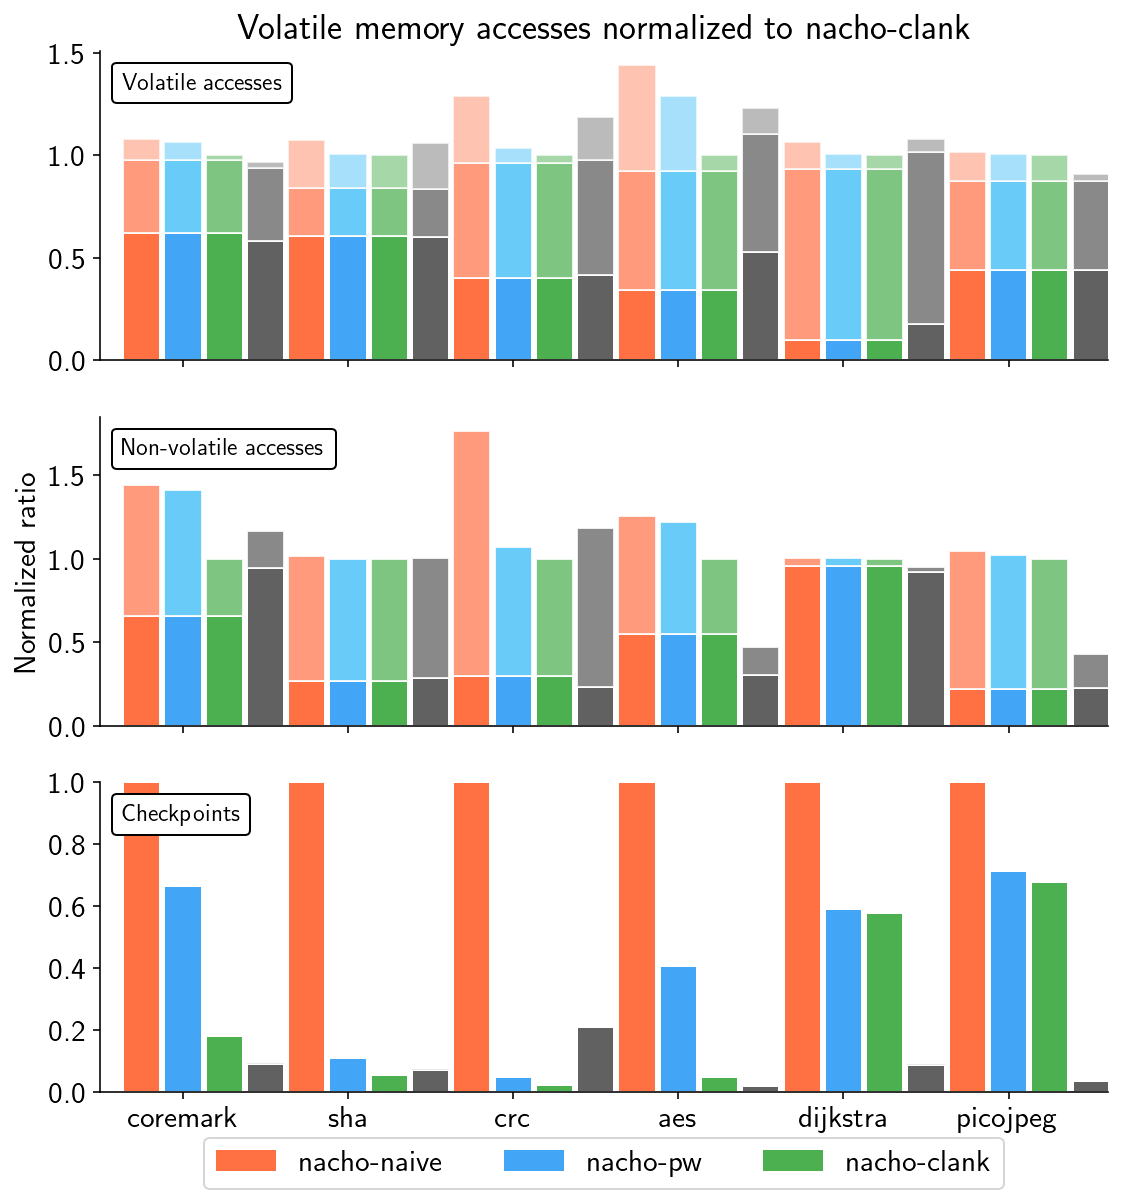

In [25]:

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8,8));
fig.tight_layout(pad=1);
ylegend = 1.2
for a in ax:
    a.set_ylim(auto=True)
    a.set_xlim(-0.25,5.85);
    a.margins(x=0);
    a.spines['right'].set_visible(False);
    a.spines['top'].set_visible(False);

ax[0].set_xticks(X + 0.25, Benchmarks);
isCheckpoints = False

# Uncomment/change what stats which are needed to be plotted
stats_plotted = ['cache_read', 'cache_write', 'cache_checkpoint']
stats_desc = ['read', 'write', 'checkpoint']
title = 'Volatile memory accesses'
normalizationBmark = "nacho-clank"

# stats_plotted = ['nvm_reads', 'nvm_writes']
# stats_desc = ['reads', 'writes']
# title = 'Non volatile memory access'
# normalizationBmark = "nacho-naive"

# stats_plotted = ['checkpoint_war', 'checkpoint_dirty', 'checkpoint_period']
# stats_desc = ['WAR', 'ditry ratio', 'period']
# title = 'Number of Checkpoints'
# normalizationBmark = "nacho-naive"
# isCheckpoints = True

# Do the actual plotting
cache_config_used = "-512-2-"
plotStatPerBenchmark(ax[0], ['cache_read', 'cache_write', 'cache_checkpoint'], normalizationBmark, title);
# Set an anchored text for the cache size
at = AnchoredText("Volatile accesses", prop=dict(size=12), frameon=True, loc='upper left')
at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
ax[0].add_artist(at)
ax[0].set_ylabel("")

plotStatPerBenchmark(ax[1], ['nvm_reads', 'nvm_writes'], normalizationBmark, "");
at = AnchoredText("Non-volatile accesses", prop=dict(size=12), frameon=True, loc='upper left')
at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
ax[1].add_artist(at)

plotStatPerBenchmark(ax[2], ['checkpoint_war', 'checkpoint_dirty', 'checkpoint_period'], "nacho-naive", "");
at = AnchoredText("Checkpoints", prop=dict(size=12), frameon=True, loc='upper left')
at.patch.set_boxstyle("round, pad=0., rounding_size=0.2")
ax[2].add_artist(at)
ax[2].set_ylabel("")

# For the legend
n=[];
h,l = ax[1].get_legend_handles_labels();
labels = Configurations;

for i in range(len(Benchmarks)):
    n.append(ax[1].bar(0, 0, color=StackedBarColors[i][3]));

if labels is not None:
    l2 = plt.legend(n, labels, bbox_to_anchor=(0., -0.282, 1., .102), 
            loc='center', fancybox=True,
            ncol=4);

# if isCheckpoints is not True:
#     # Add a manual legend for the stats
#     for a in ax[0:1]:
#         ybase = ylegend
#         idx = 0
#         xbase = 4.75
#         a.add_patch(Rectangle((xbase-0.08, ybase-0.08), 1, 0.1 * len(stats_desc) + 0.2, fill=False));
#         for e in stats_plotted:
#             statsLegend = a.add_patch(Rectangle((xbase, ybase), 0.2, 0.05));
#             statsLegend.set(color=StackedBarColors[3][3 - idx], alpha=1 - 0.15 * idx);
#             a.text(xbase + 0.25, ybase, stats_desc[idx], fontsize='small');
#             ybase = ybase + 0.1;
#             idx = idx + 1;
#         a.text(xbase, ybase+0.02, "Accesses during a", fontsize='small');
